## Cognition and conditioning
We have built up a tool set for constructing probabilistic generative models. These can represent knowledge about causal processes in the world: running one of these programs generates a particular outcome by sampling a “history” for that outcome. However, the power of a causal model lies in the flexible ways it can be used to reason about the world. In the last chapter we ran generative models forward to reason about outcomes from initial conditions. Generative models also enable reasoning in other ways. For instance, if we have a generative model in which X is the output of a process that depends on Y (say `X = coolFunction(Y)`) we may ask: “assuming I have observed a certain X, what must Y have been?” That is we can reason backward from outcomes to initial conditions. More generally, we can make hypothetical assumptions and reason about the generative history: “assuming something, how did the generative model run?” In this section we describe how a wide variety of such hypothetical inferences can be made from a single generative model by conditioning the model on an assumed or observed fact.

Much of cognition can be understood in terms of conditional inference. In its most basic form, causal attribution is conditional inference: given some observed effects, what were the likely causes? Predictions are conditional inferences in the opposite direction: given that I have observed some cause, what are its likely effects? These inferences can be described by conditioning a probabilistic program that expresses a causal model. The acquisition of that causal model, or learning, is also conditional inference at a higher level of abstraction: given our general knowledge of how causal relations operate in the world, and some observed events in which candidate causes and effects co-occur in various ways, what specific causal relations are likely to hold between these observed variables?

To see how the same concepts apply in a domain that is not usually thought of as causal, consider language. The core questions of interest in the study of natural language are all at heart conditional inference problems. Given beliefs about the structure of my language, and an observed sentence, what should I believe about the syntactic structure of that sentence? This is the parsing problem. The complementary problem of speech production is related: given the structure of my language (and beliefs about others’ beliefs about that), and a particular thought I want to express, how should I encode the thought? Finally, the acquisition problem: given some data from a particular language, and perhaps general knowledge about universals of grammar, what should we believe about that language’s structure? This problem is simultaneously the problem facing the linguist and the child trying to learn a language.

Parallel problems of conditional inference arise in visual perception, social cognition, and virtually every other domain of cognition. In visual perception, we observe an image or image sequence that is the result of rendering a three-dimensional physical scene onto our two-dimensional retinas. A probabilistic program can model both the physical processes at work in the world that produce natural scenes, and the imaging processes (the “graphics”) that generate images from scenes. Perception can then be seen as conditioning this program on some observed output image and inferring the scenes most likely to have given rise to it.

When interacting with other people, we observe their actions, which result from a planning process, and often want to guess their desires, beliefs, emotions, or future actions. Planning can be modeled as a program that takes as input an agent’s mental states (beliefs, desires, etc.) and produces action sequences—for a rational agent, these will be actions that are likely to produce the agent’s desired states reliably and efficiently. A rational agent can plan their actions by conditional inference to infer what steps would be most likely to achieve their desired state. Action understanding, or interpreting an agent’s observed behavior, can be expressed as conditioning a planning program (a “theory of mind”) on observed actions to infer the mental states that most likely gave rise to those actions, and to predict how the agent is likely to act in the future.

### Reasoning with inference
Suppose that we know some fixed fact, and we wish to consider hypotheses about how a generative model could have given rise to that fact. using if statments, latent variables and infernce function we can describe the conditional distributions 

Consider the following simple generative model:

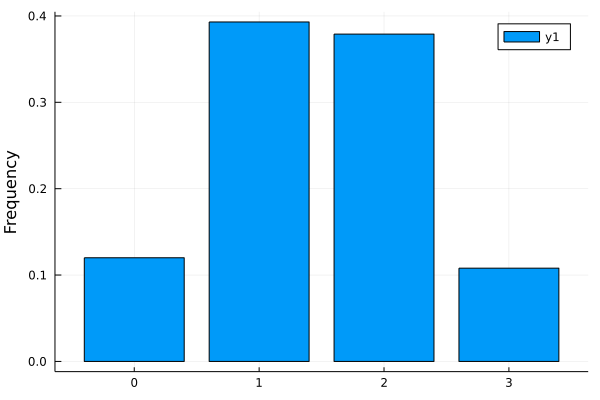

In [30]:
using Gen
include("auxilery.jl")
@gen function model()
    a=@trace(bernoulli(0.5),:a)
    b=@trace(bernoulli(0.5),:b)
    c=@trace(bernoulli(0.5),:c)
    d=a+b+c
end
simulate(model,())
ys=[model() for _ in 1:1000]
viz(ys)

The process described in `model` samples three numbers and adds them (recall Julia converts booleans to 0 or 1 when they enter arithmetic). The value of the final expression here is 0, 1, 2 or 3. A priori, each of the variables `A`, `B`, `C` has .5 probability of being `1` or `0`. However, suppose that we know that the sum D is equal to 3. How does this change the space of possible values that variable `A` could have taken? `A` (and `B` and `C`) must be equal to 1 for this result to happen. We can see this in the following Julia inference, where we use a latent variable in the model and choicemap in the inference function to express the desired assumption:

In [31]:
function importence_resamplin_inference(model, var,value, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    observations[var] = value
           
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (), observations, amount_of_computation);
    return trace
end;

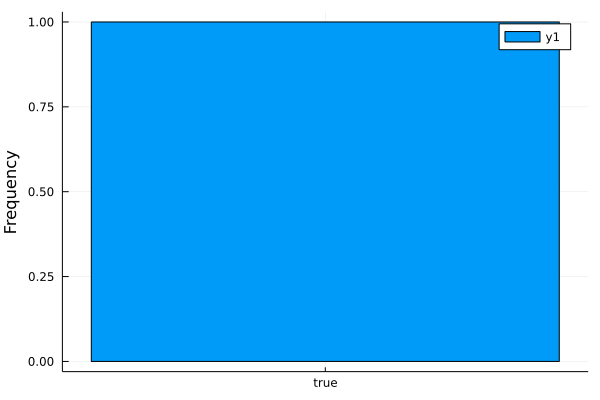

In [32]:
@gen function model2()
    a = @trace(bernoulli(0.5),:a)
    b = @trace(bernoulli(0.5),:b)
    c = @trace(bernoulli(0.5),:c)
    d = a+b+c
    if d == 3
        @trace(bernoulli(0.9999),:"d==3")
    else
        @trace(bernoulli(0.00001),:"d==3")    
    end
    d
end
ys=[]
for _ in 1:1000
    trace = importence_resamplin_inference(model2, "d==3",true, 100)
    push!(ys,trace[:a])
end
viz(ys)

The output of `importence_resamplin_inference` is a trace that describes appropriate beliefs about the likely value of `a`,`b`,`c` conditioned on `d` being equal to 3.

Now suppose that we condition on `d` being greater than or equal to 2. Then `a` need not be 1, but it is more likely than not to be. (Why?) The corresponding plot shows the appropriate distribution of beliefs for `A` conditioned on this new fact:

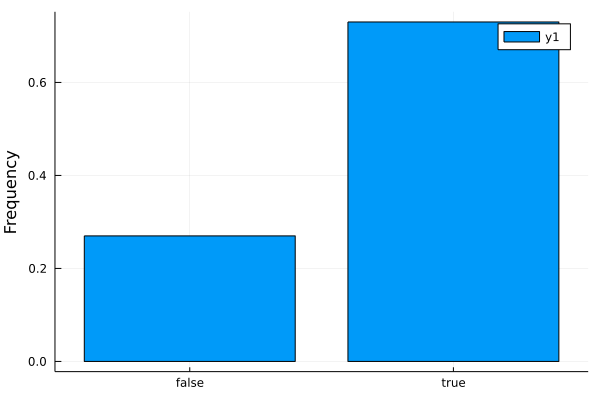

In [37]:
@gen function model3()
    a=@trace(bernoulli(0.5),:a)
    b=@trace(bernoulli(0.5),:b)
    c=@trace(bernoulli(0.5),:c)
    if a+b+c >= 2
        @trace(bernoulli(0.999),:"d>=2")
    else
        @trace(bernoulli(0.001),:"d>=2")
    end
end
ys=[]
for _ in 1:100
trace=importence_resamplin_inference(model3, "d>=2",true, 100)
    push!(ys,trace[:a])
end
viz(ys)

Going beyond the basic intuition of “hypothetical reasoning”,  infernce in the presence of condition can be understood in several, equivalent, ways. We focus on two: the process of rejection sampling, and the the mathematical formulation of a conditional distribution

### Rejection Sampling
How can we imagine answering a hypothetical such as those above? We have already seen how to get a sample from a generative model, without constraint, by simply running the evaluation process “forward” (i.e. simulating the process). We can get conditional samples by forward sampling the entire model, but only keeping the sample if the value passed to condition is true. For instance, to sample from the above model “a given that d is greater than 2” we could:

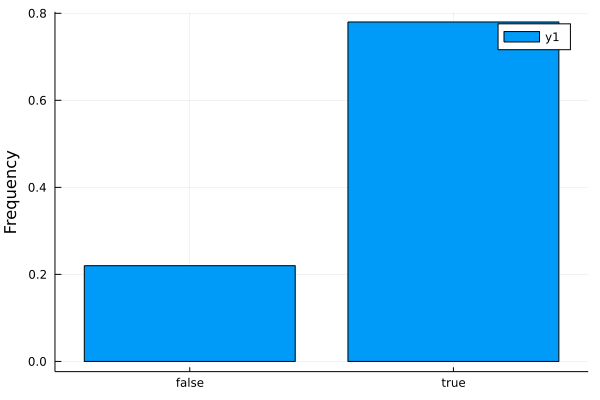

In [38]:
@gen function takeSample()
    a = @trace(bernoulli(0.5),:a)
    b = @trace(bernoulli(0.5),:b)
    c = @trace(bernoulli(0.5),:c)
    d = a+b+c
    d >=2 ? a : takeSample()
end
ys = [takeSample() for _ in 1:100]
viz(ys)

Notice that we have used a stochastic recursion to sample the model repeatedly until `d >= 2` is `true`, and we then return `a`: we generate and test until the condition is satisfied. This process is known as rejection sampling; we can use this technique to make a more general function that implements infernce, :

In [39]:
function rejection_sampeling(model,args,pred)
    trace=simulate(model,args)
    pred(trace) ? trace : rejection_sampeling(model,args,pred)
end

rejection_sampeling (generic function with 1 method)

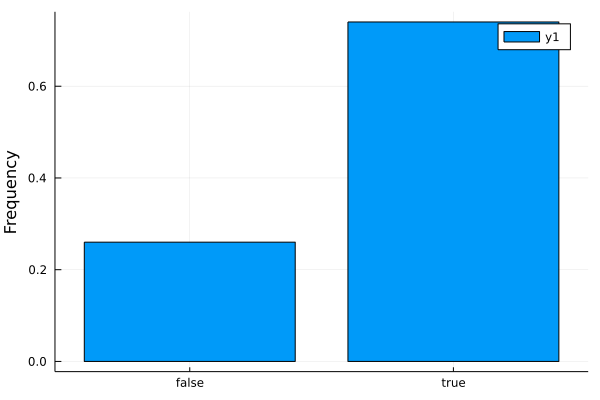

In [40]:
ys=[]
for _ in 1:100
trace = rejection_sampeling(model3,(), x-> x["d>=2"])
    push!(ys,trace[:a])
end
viz(ys)